Adapted from: https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/hierarchical.ipynb

In [1]:
%pylab --no-import-all inline

from pymc3 import *
import theano.tensor as T
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
random.seed(1)

Basic HLM
===

In [3]:
# Set up basic parameters
n_markets = 4
no_permarket = 30
n_observed = no_permarket * n_markets
n_predictors = 3

In [4]:
n_observed

120

In [5]:
# Set up markets
market = concatenate([[i] * no_permarket for i in range(n_markets)])

# Simulate the features
predictors = random.normal(size=(n_observed, n_predictors))

In [6]:
market

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3])

In [7]:
# Choose random values to represent the actual alphas and betas
alpha_a = random.normal(size=(n_markets))
beta_a = random.normal(size=(n_markets, n_predictors))

In [8]:
alpha_a

array([-0.55749472,  0.93916874, -1.94332341,  0.35249436])

In [9]:
beta_a

array([[-0.23643695,  0.7278135 ,  0.51507361],
       [-2.78253447,  0.58464661,  0.32427424],
       [ 0.02186284, -0.46867382,  0.85328122],
       [-0.41302931,  1.83471763,  0.56438286]])

In [10]:
# Calculate the actual data, but put a bit of noise in
y = alpha_a[market] + nsum(beta_a[market] * predictors, 1) + random.normal(size=(n_observed))

In [11]:
y.shape

(120,)

In [12]:
predictors.shape

(120, 3)

In [15]:
# Set up the PyMC model
model = Model()
with model:
    
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = Normal("mu_alpha", 0, 10, shape=(1))
    sigma_alpha = Uniform("sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = Normal("mu_beta", 0, 10, shape=(1))
    sigma_beta = Uniform("sigma_beta", .0, 10, testval=2.)
    
    # Simulate the alphas
    alpha = Normal("alpha", mu_alpha, sigma_alpha, shape=(n_markets))
    
    # Simulate the betas
    beta = Normal('beta', mu_beta, sigma_beta, shape=(n_markets, n_predictors))
    
    m = T.constant(market)
    
    # Simulate the noise
    s = Uniform("s", .01, 10, shape=n_markets)

    yd = Normal('y', alpha[m] + sum(beta[m] * predictors, 1), s[m] ** -2, observed=y)

    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    step = NUTS()

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval_ to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval_ to model.
Applied interval-transform to s and added transformed s_interval_ to model.


In [16]:
# Actually sample the model
tr = sample(3e4, step, model=model)

 [-----------------100%-----------------] 30000 of 30000 complete in 133.2 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125571828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126440940>]], dtype=object)

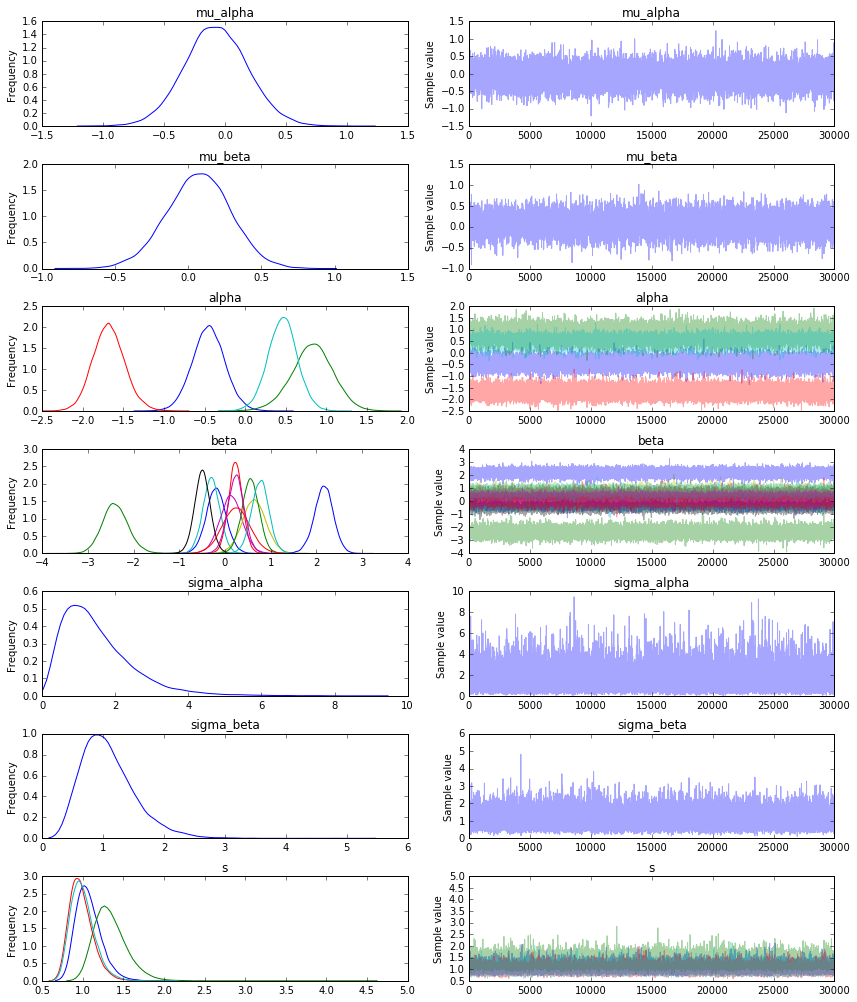

In [17]:
# Plot the variables
traceplot(tr)

In [18]:
# See a summary
summary(tr)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.072           0.261            0.003            [-0.612, 0.416]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.582         -0.245         -0.074         0.102          0.448


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.070            0.220            0.003            [-0.352, 0.512]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.371         -0.075         0.073          0.219          0.494


alpha:

  Mean             SD               MC Error         95% HPD interval
  ------------------

In [19]:
alpha_a

array([-0.55749472,  0.93916874, -1.94332341,  0.35249436])

In [20]:
beta_a

array([[-0.23643695,  0.7278135 ,  0.51507361],
       [-2.78253447,  0.58464661,  0.32427424],
       [ 0.02186284, -0.46867382,  0.85328122],
       [-0.41302931,  1.83471763,  0.56438286]])